<a href="https://colab.research.google.com/github/rpujala/machine_learning/blob/main/Supplier_Delay_Risk_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supplier Delay Risk Scoring

* The global supply chain operations team manages hundreds of suppliers across multiple countries and shipment modes.

* Repeated supplier delays have led to SLA breaches, downstream production delays, and penalty disputes. However, planners currently react after a delay occurs.

* To proactively manage supplier risk, the team wants a **machine learning system that predicts the probability of a supplier delay** for an upcoming shipment, enabling early intervention such as expediting, rerouting, or supplier escalation.

* The model must be explainable, robust to missing data, and usable for risk-based SLA enforcement.

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

n_samples = 7000
n_suppliers = 80

data = {
    'supplier_id': np.random.choice([f"S_{i}" for i in range(n_suppliers)], n_samples),
    'supplier_country': np.random.choice(["CN", "IN", "VN", "US", "DW"], n_samples,
                                        p=[0.35, 0.25, 0.15, 0.15, 0.10]),
    'shipment_mode': np.random.choice(['Air', 'Road', 'Sea'], n_samples, p=[0.3, 0.5, 0.2]),
    'past_delay_rate': np.random.uniform(0, 0.6, n_samples),
    'avg_delay_days': np.random.uniform(0, 15, n_samples),
    'shipments_last_30d': np.random.randint(1, 40, n_samples),
    'lead_time_days': np.random.randint(5, 40, n_samples),
    'contract_sla_days': np.random.randint(10, 30, n_samples),
    'is_peak_season': np.random.choice([0, 1], n_samples, p=[0.7, 0.3])
}

df = pd.DataFrame(data=data)
df.head()

,supplier_id,supplier_country,shipment_mode,past_delay_rate,avg_delay_days,shipments_last_30d,lead_time_days,contract_sla_days,is_peak_season
0,S_51,CN,Air,0.443386,4.651392,1,20,11,0
1,S_14,IN,Road,0.150992,6.692009,9,6,11,0
2,S_71,DW,Road,0.538056,10.030593,31,11,22,0
3,S_60,CN,Air,0.336853,11.315528,24,25,22,1
4,S_20,DW,Road,0.322699,6.512192,22,35,12,1


In [ ]:
risk_score = (
    0.6 * df['past_delay_rate'] +
    0.02 * df['avg_delay_days'] +
    0.15 * df['is_peak_season'] +
    0.1 * (df['shipment_mode'] == 'Sea').astype(int)
)

prob = 1 / (1 + np.exp(-5 * (risk_score - 0.35)))
df['delay_occured'] = (np.random.rand(n_samples) < prob).astype(int)

In [ ]:
df.head()

,supplier_id,supplier_country,shipment_mode,past_delay_rate,avg_delay_days,shipments_last_30d,lead_time_days,contract_sla_days,is_peak_season,delay_occured
0,S_51,CN,Air,0.443386,4.651392,1,20,11,0,0
1,S_14,IN,Road,0.150992,6.692009,9,6,11,0,0
2,S_71,DW,Road,0.538056,10.030593,31,11,22,0,1
3,S_60,CN,Air,0.336853,11.315528,24,25,22,1,1
4,S_20,DW,Road,0.322699,6.512192,22,35,12,1,1


# Check for missing values

In [ ]:
import numpy as np

df.replace('', np.nan, inplace=True)
df.isna().sum()

supplier_id           0
supplier_country      0
shipment_mode         0
past_delay_rate       0
avg_delay_days        0
shipments_last_30d    0
lead_time_days        0
contract_sla_days     0
is_peak_season        0
delay_occured         0
dtype: int64

# Feature / Target split

In [ ]:
df.head()

,supplier_id,supplier_country,shipment_mode,past_delay_rate,avg_delay_days,shipments_last_30d,lead_time_days,contract_sla_days,is_peak_season,delay_occured
0,S_51,CN,Air,0.443386,4.651392,1,20,11,0,0
1,S_14,IN,Road,0.150992,6.692009,9,6,11,0,0
2,S_71,DW,Road,0.538056,10.030593,31,11,22,0,1
3,S_60,CN,Air,0.336853,11.315528,24,25,22,1,1
4,S_20,DW,Road,0.322699,6.512192,22,35,12,1,1


In [ ]:
X = df.drop(columns=['delay_occured', 'supplier_id'], axis=1)
y = df['delay_occured']

In [ ]:
X[:2]

,supplier_country,shipment_mode,past_delay_rate,avg_delay_days,shipments_last_30d,lead_time_days,contract_sla_days,is_peak_season
0,CN,Air,0.443386,4.651392,1,20,11,0
1,IN,Road,0.150992,6.692009,9,6,11,0


In [ ]:
y[:2]

0    0
1    0
Name: delay_occured, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y)

In [ ]:
X_train.shape, y_train.shape

((5600, 8), (5600,))

In [ ]:
X_test.shape, y_test.shape

((1400, 8), (1400,))

# Preprocessing Pipeline (Production-Grade)

In [ ]:
df.head()

,supplier_id,supplier_country,shipment_mode,past_delay_rate,avg_delay_days,shipments_last_30d,lead_time_days,contract_sla_days,is_peak_season,delay_occured
0,S_51,CN,Air,0.443386,4.651392,1,20,11,0,0
1,S_14,IN,Road,0.150992,6.692009,9,6,11,0,0
2,S_71,DW,Road,0.538056,10.030593,31,11,22,0,1
3,S_60,CN,Air,0.336853,11.315528,24,25,22,1,1
4,S_20,DW,Road,0.322699,6.512192,22,35,12,1,1


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
X[:2]

,supplier_country,shipment_mode,past_delay_rate,avg_delay_days,shipments_last_30d,lead_time_days,contract_sla_days,is_peak_season
0,CN,Air,0.443386,4.651392,1,20,11,0
1,IN,Road,0.150992,6.692009,9,6,11,0


In [ ]:
num_features = [
    'past_delay_rate',
    'avg_delay_days',
    'shipments_last_30d',
    'lead_time_days',
    'contract_sla_days'
]

cat_features = [
    'supplier_country',
    'shipment_mode',
    'is_peak_season',
]

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_features),
    ('cat_pipeline', cat_pipeline, cat_features)
])

preprocessor

,transformers,"[('num_pipeline', ...), ('cat_pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


# Transform for TensorFlow

In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
X_train_processed = X_train_processed.astype('float')
X_test_processed = X_test_processed.astype('float')

In [ ]:
type(X_train_processed), type(X_test_processed)

(numpy.ndarray, numpy.ndarray)

# TensorFlow Sequential Model

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_processed.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.AUC(name='auc')])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 64)                1024      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import os
from datetime import datetime

log_dir = "logs/fit/" + datetime.now().strftime('%Y%m%d-%H%M%S')

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="myModel_{epoch:02d}.keras",
        save_best_only=True,
        monitor='val_loss',
        verbose=2),

    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=5,
        verbose=2),

    tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1)
]

model.fit(
    X_train_processed,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/5

Epoch 1: val_loss improved from inf to 0.64385, saving model to myModel_01.keras
140/140 - 2s - loss: 0.6635 - binary_accuracy: 0.5480 - auc: 0.6206 - val_loss: 0.6438 - val_binary_accuracy: 0.5607 - val_auc: 0.6590 - 2s/epoch - 13ms/step
Epoch 2/5

Epoch 2: val_loss improved from 0.64385 to 0.63509, saving model to myModel_02.keras
140/140 - 0s - loss: 0.6353 - binary_accuracy: 0.6027 - auc: 0.6682 - val_loss: 0.6351 - val_binary_accuracy: 0.5982 - val_auc: 0.6737 - 494ms/epoch - 4ms/step
Epoch 3/5

Epoch 3: val_loss did not improve from 0.63509
140/140 - 0s - loss: 0.6265 - binary_accuracy: 0.6129 - auc: 0.6819 - val_loss: 0.6378 - val_binary_accuracy: 0.6187 - val_auc: 0.6733 - 465ms/epoch - 3ms/step
Epoch 4/5

Epoch 4: val_loss did not improve from 0.63509
140/140 - 0s - loss: 0.6259 - binary_accuracy: 0.6205 - auc: 0.6795 - val_loss: 0.6362 - val_binary_accuracy: 0.6071 - val_auc: 0.6733 - 466ms/epoch - 3ms/step
Epoch 5/5

Epoch 5: val_loss did not improve from 0.63509


# Evaluation

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

pred_probs = model.predict(X_test_processed).flatten()
y_preds = (pred_probs > 0.5).astype(int)
y_preds[:5]

44/44 [==============================] - 0s 1ms/step


array([0, 1, 1, 0, 1])

In [ ]:
y_test[:5]

1408    0
2425    1
1870    0
3406    0
4270    0
Name: delay_occured, dtype: int64

In [ ]:
print(f"Classification Report: {classification_report(y_test, y_preds)}")

Classification Report:               precision    recall  f1-score   support

           0       0.54      0.79      0.64       626
           1       0.73      0.46      0.56       774

    accuracy                           0.61      1400
   macro avg       0.63      0.62      0.60      1400
weighted avg       0.64      0.61      0.60      1400



In [ ]:
print(f"ROC-AUC: {roc_auc_score(y_test, y_preds)}")

ROC-AUC: 0.6237441282578365


# Feature Importance

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import permutation_importance


class KerasWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        super().__init__()

        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

wrapped_model = KerasWrapper(model)
wrapped_model

,model,<keras.engine...x7fe9458a9ba0>


In [ ]:
result = permutation_importance(
    estimator=wrapped_model,
    X=X_test_processed,
    y=y_test,
    n_repeats=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=1
)

print("Feature Importance computed successfully")
print(result.importances_mean)

44/44 [==============================] - 0s 1ms/step
Feature Importance computed successfully
[ 6.90307379e-02  4.20781136e-02 -2.32458115e-05  7.92145729e-04
  1.26678944e-03  2.10525990e-03  2.90781260e-03  3.31830978e-04
  5.64730167e-04  2.10665464e-03 -6.19589090e-03 -2.54108906e-03
 -3.79174948e-03 -4.39713001e-03 -9.41369534e-03]


In [ ]:
preprocessor.get_feature_names_out()

array(['num_pipeline__past_delay_rate', 'num_pipeline__avg_delay_days',
       'num_pipeline__shipments_last_30d', 'num_pipeline__lead_time_days',
       'num_pipeline__contract_sla_days',
       'cat_pipeline__supplier_country_CN',
       'cat_pipeline__supplier_country_DW',
       'cat_pipeline__supplier_country_IN',
       'cat_pipeline__supplier_country_US',
       'cat_pipeline__supplier_country_VN',
       'cat_pipeline__shipment_mode_Air',
       'cat_pipeline__shipment_mode_Road',
       'cat_pipeline__shipment_mode_Sea',
       'cat_pipeline__is_peak_season_0', 'cat_pipeline__is_peak_season_1'],
      dtype=object)

<Axes: >

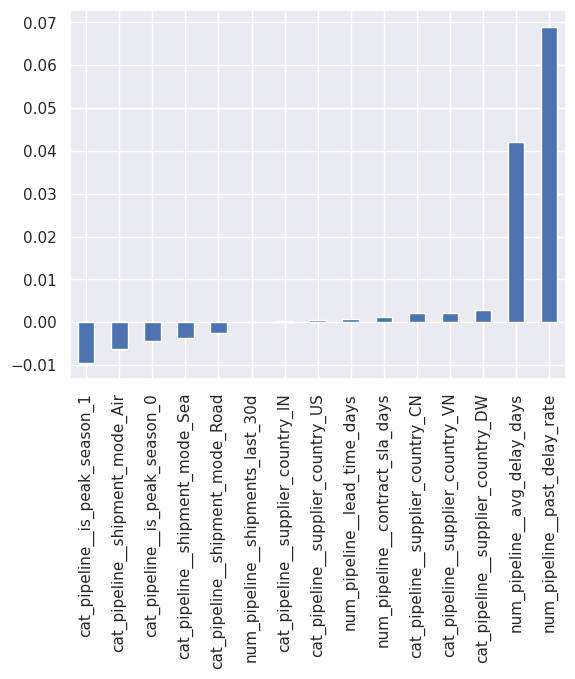

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = preprocessor.get_feature_names_out()

importance_df = pd.Series(result.importances_mean, index=feature_names)
importance_df = importance_df.sort_values(ascending=True)
importance_df.plot(kind='bar')

In [ ]:
importance_df

cat_pipeline__is_peak_season_1      -0.009414
cat_pipeline__shipment_mode_Air     -0.006196
cat_pipeline__is_peak_season_0      -0.004397
cat_pipeline__shipment_mode_Sea     -0.003792
cat_pipeline__shipment_mode_Road    -0.002541
num_pipeline__shipments_last_30d    -0.000023
cat_pipeline__supplier_country_IN    0.000332
cat_pipeline__supplier_country_US    0.000565
num_pipeline__lead_time_days         0.000792
num_pipeline__contract_sla_days      0.001267
cat_pipeline__supplier_country_CN    0.002105
cat_pipeline__supplier_country_VN    0.002107
cat_pipeline__supplier_country_DW    0.002908
num_pipeline__avg_delay_days         0.042078
num_pipeline__past_delay_rate        0.069031
dtype: float64

# TF Datasets

* This is the effective method to implement when we have less memory systems

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                 y_train,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify=y_train)

In [ ]:
X_train.shape, y_train.shape

((4480, 8), (4480,))

In [ ]:
X_test.shape, y_test.shape

((1400, 8), (1400,))

In [ ]:
X_val.shape, y_val.shape

((1120, 8), (1120,))

In [ ]:
preprocessor

,transformers,"[('num_pipeline', ...), ('cat_pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_processed, y_train))
train_ds = train_ds.shuffle(1000).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_processed, y_val))
val_ds = val_ds.shuffle(1000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_processed, y_test))

In [ ]:
model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/5

Epoch 1: val_loss improved from 0.63509 to 0.62766, saving model to myModel_01.keras
140/140 - 1s - loss: 0.6279 - binary_accuracy: 0.6181 - auc: 0.6757 - val_loss: 0.6277 - val_binary_accuracy: 0.5982 - val_auc: 0.6807 - 1s/epoch - 8ms/step
Epoch 2/5

Epoch 2: val_loss did not improve from 0.62766
140/140 - 1s - loss: 0.6220 - binary_accuracy: 0.6266 - auc: 0.6892 - val_loss: 0.6289 - val_binary_accuracy: 0.6214 - val_auc: 0.6814 - 507ms/epoch - 4ms/step
Epoch 3/5

Epoch 3: val_loss did not improve from 0.62766
140/140 - 1s - loss: 0.6238 - binary_accuracy: 0.6212 - auc: 0.6859 - val_loss: 0.6296 - val_binary_accuracy: 0.6009 - val_auc: 0.6759 - 503ms/epoch - 4ms/step
Epoch 4/5

Epoch 4: val_loss did not improve from 0.62766
140/140 - 1s - loss: 0.6203 - binary_accuracy: 0.6333 - auc: 0.6913 - val_loss: 0.6299 - val_binary_accuracy: 0.5955 - val_auc: 0.6774 - 511ms/epoch - 4ms/step
Epoch 5/5

Epoch 5: val_loss did not improve from 0.62766
140/140 - 1s - loss: 0.6209 - binar